In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

Center (32.06187566669529, 19.88837932673825)
Radius 14.694300400513793


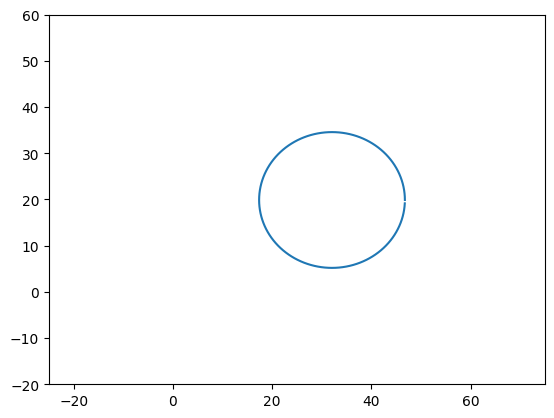

In [2]:
pi = 3.1415

cx = random.random() * 50
cy = random.random() * 50
cr = random.random() * 25

i = 0
cp = []
while i <= 2 * pi:
    px = cx + math.cos(i) * cr
    py = cy + math.sin(i) * cr
    cp.append((px, py))
    i += pi / 64
cp = np.array(cp)

print("Center", (cx, cy))
print("Radius", cr)

plt.plot(cp[:, 0], cp[:, 1])
plt.xlim([-25, 75])
plt.ylim([-20, 60])
plt.show()

In [3]:
class RANSAC:
    def __init__(self, x_data, y_data, n):
        self.x_data = x_data
        self.y_data = y_data
        self.n = n
        self.d_min = 99999
        self.best_model = None

    def random_sampling(self):
        sample_indices = np.random.choice(len(self.x_data), 3, replace=False)
        sample = list(zip([self.x_data[i] for i in sample_indices], [
                      self.y_data[i] for i in sample_indices]))

        return sample

    def make_model(self, sample):
        try:
            pt1 = sample[0]
            pt2 = sample[1]
            pt3 = sample[2]

            A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]],
                         [pt3[0] - pt2[0], pt3[1] - pt2[1]]])
            B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2],
                         [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])
            try:
                if (np.linalg.det(A) == 0):
                    return None
                inv_A = inv(A)
                c_x, c_y = np.dot(inv_A, B) / 2
                c_x, c_y = c_x[0], c_y[0]
                r = np.sqrt((c_x - pt1[0])**2 + (c_y - pt1[1])**2)
                return c_x, c_y, r,
            except:
                self.best_model = None
                return None
        except:
            return None

    def eval_model(self, model):
        c_x, c_y, r = model
        distances = np.sqrt((self.x_data-c_x)**2 + (self.y_data-c_y)**2)
        d = np.sum(np.abs(distances - r))
        return d

    def execute_ransac(self):
        # find best model
        for i in range(self.n):
            model = self.make_model(self.random_sampling())
            if model is not None:
                d_temp = self.eval_model(model)
                if self.d_min > d_temp:
                    self.best_model = model
                    self.d_min = d_temp

In [4]:
class LSC:
    def __init__(self, points):
        self.points = points
    
    def compute(self):
        x = self.points[:, 0]
        y = self.points[:, 1]
        n = len(self.points)
        
        sxsq = np.sum(x ** 2)
        sysq = np.sum(y ** 2)
        sxy = np.sum(x * y)
        sx = np.sum(x)
        sy = np.sum(y)
        
        left = np.array([
            [sxsq, sxy, sx],
            [sxy, sysq, sy],
            [sx, sy, n],
        ])
        
        right = np.array([
            np.sum(x * (x ** 2 + y ** 2)),
            np.sum(y * (x ** 2 + y ** 2)),
            np.sum(x ** 2 + y ** 2),
        ])
        
        sol = np.dot(np.linalg.inv(left), right)
        
        A, B, C = sol
        
        k = A / 2
        m = B / 2
        r = (np.sqrt(4 * C + A ** 2 + B ** 2)) / 2
        
        return k, m, r

In [8]:
%%time

ransac = RANSAC(cp[:, 0], cp[:, 1], 25)
ransac.execute_ransac()

if not ransac.best_model:
    print("Failed")
else:
    print(ransac.best_model)

(32.06187566669529, 19.88837932673825, 14.694300400513793)
CPU times: total: 0 ns
Wall time: 11.1 ms


In [9]:
%%time

LSC(cp).compute()

CPU times: total: 0 ns
Wall time: 1e+03 µs


(32.06187566669527, 19.888379326738253, 14.69430040051379)